In [1]:
!pip install nibabel monai matplotlib torch scipy pandas numpy ipywidgets

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Visualise original scans
import os
import glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

# Define paths
data_path_secret = r'./Secret3d'
data_path_acdc = r'./database'

# Load a scan
def load_nii(img_path):
    nimg = nib.load(img_path)
    return nimg.get_fdata()

# Get list of scans
def get_scan_paths_secret(data_path):
    patient_dirs = [os.path.join(data_path, patient) for patient in os.listdir(data_path) 
                    if os.path.isdir(os.path.join(data_path, patient))]
    
    image_paths = []
    for patient_folder in patient_dirs:
        image_paths.extend(sorted(glob.glob(os.path.join(patient_folder, "*.nii.gz"))))
    
    return sorted(image_paths)

def get_scan_paths_acdc(data_path):
    
    image_dir = os.path.join(data_path, "testing", "image")
    
    image_paths = sorted(glob.glob(os.path.join(image_dir, "*.nii.gz")))
    
    return image_paths

# Get scan paths
scan_paths = get_scan_paths_secret(data_path_secret)
#scan_paths = get_scan_paths_acdc(data_path_acdc)

scan_dict = {os.path.basename(p): p for p in scan_paths}  # Dropdown options

# Visualization function
def display_scan(scan_name):
    img_path = scan_dict[scan_name]
    img_data = load_nii(img_path)
    
    # Slider for slices
    def plot_slice(slice_idx):
        plt.figure(figsize=(6,6))
        plt.imshow(img_data[:, :, slice_idx], cmap="gray")
        plt.axis("off")
        plt.show()

    interact(plot_slice, slice_idx=widgets.IntSlider(min=0, max=img_data.shape[2]-1, step=1, value=img_data.shape[2]//2))

# Dropdown menu
interact(display_scan, scan_name=widgets.Dropdown(options=scan_dict.keys(), description="Scan:"));


/home/jovyan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


interactive(children=(Dropdown(description='Scan:', options=('patient151_frame01.nii.gz', 'patient152_frame01.…

2025-04-01 09:48:08.599291: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-01 09:48:08.638231: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-01 09:48:08.638256: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-01 09:48:08.638288: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-01 09:48:08.647096: I tensorflow/core/platform/cpu_feature_g

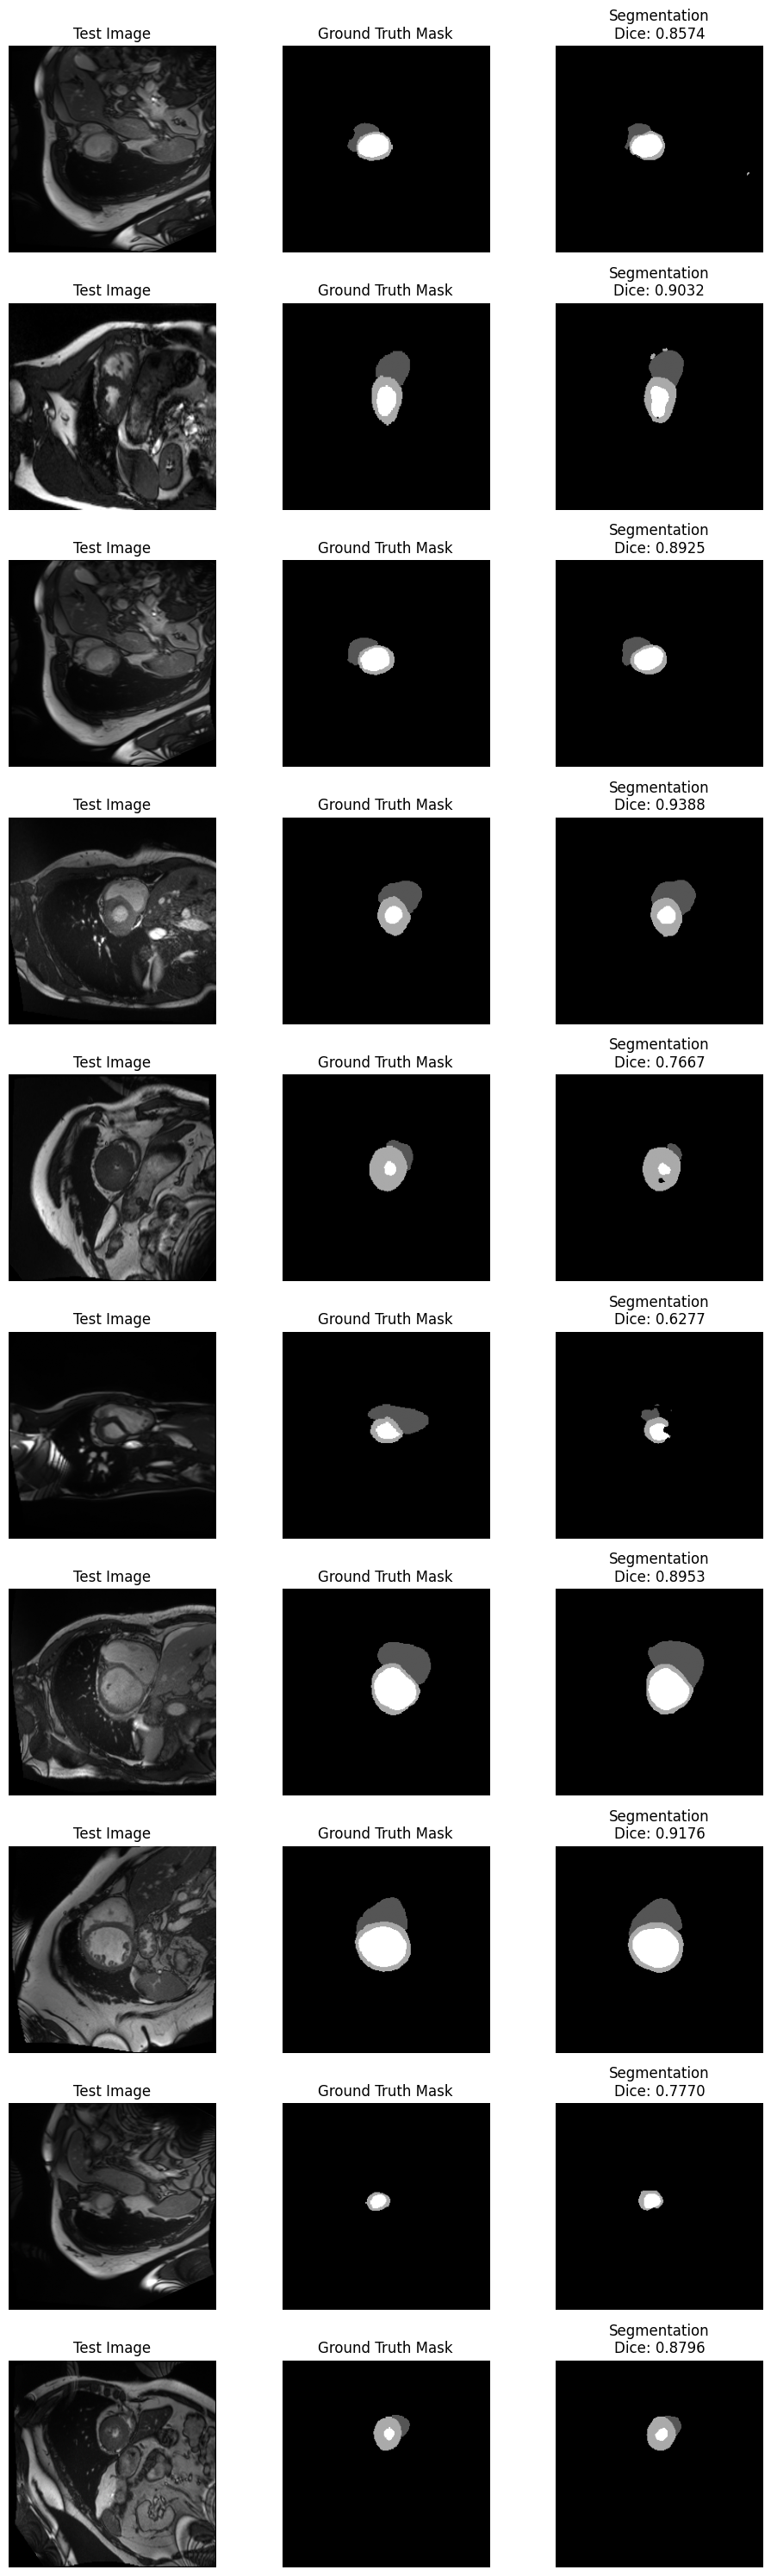

In [3]:
# Visualisation, including dice per visualised slice, ACDC test set
import os
import glob
import torch
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import monai
from monai.transforms import Compose, EnsureChannelFirstd, ScaleIntensityd, Resized
from monai.networks.nets import UNet
from monai.metrics import DiceMetric
from monai.networks.utils import one_hot
from torch.utils.data import DataLoader
import random

ensemble_model_path = "ensembleHeartUNet.pt"

#%% Load NIfTI images
def load_nii(img_path):
    nimg = nib.load(img_path)
    return nimg.get_fdata()

#%% Build a dictionary for the test dataset
def build_test_dict(data_path):
    image_dir = os.path.join(data_path, "testing", "image")
    mask_dir = os.path.join(data_path, "testing", "segmentation")

    image_paths = sorted(glob.glob(os.path.join(image_dir, "*.nii.gz")))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*_gt.nii.gz")))

    mask_dict = {os.path.basename(m).replace("_gt", ""): m for m in mask_paths}
    dataset_dicts = []
    for img_path in image_paths:
        filename = os.path.basename(img_path)
        mask_path = mask_dict.get(filename, None)
        if mask_path and os.path.exists(mask_path):
            dataset_dicts.append({"img": img_path, "mask": mask_path})
    return dataset_dicts

#%% Define the EnsembleModel globally to avoid pickle issues
class EnsembleModel(torch.nn.Module):
    def __init__(self, models):
        super(EnsembleModel, self).__init__()
        self.models = torch.nn.ModuleList(models)

    def forward(self, x):
        # Collect and average the predictions (soft voting)
        outputs_list = [torch.softmax(model(x), dim=1) for model in self.models]
        avg_outputs = torch.mean(torch.stack(outputs_list), dim=0)
        return avg_outputs

#%% Custom Transform to Load All Slices of Data
class LoadHeartData(monai.transforms.Transform):
    def __call__(self, sample):
        img_vol = load_nii(sample['img'])
        mask_vol = load_nii(sample['mask'])
        images = np.moveaxis(img_vol, -1, 0)
        masks = np.moveaxis(mask_vol, -1, 0)
        slice_list = []
        for i in range(images.shape[0]):
            slice_list.append({
                'img': images[i].astype(np.float32),
                'mask': masks[i].astype(np.uint8),
                'img_meta_dict': {'affine': np.eye(2)},
                'mask_meta_dict': {'affine': np.eye(2)}
            })
        return slice_list

#%% Define test transforms
test_transforms = Compose([
    LoadHeartData(),
    EnsureChannelFirstd(keys=['img', 'mask'], channel_dim="no_channel"),
    ScaleIntensityd(keys=['img']),
    Resized(keys=['img', 'mask'], spatial_size=(256, 256), mode=['bilinear', 'nearest']),
])

#%% Load and flatten the test dataset
test_dicts = build_test_dict(r'./database')
def flatten_dataset(dataset_list, transform):
    flat_list = []
    for data in dataset_list:
        flat_list.extend(transform(data))
    return flat_list

test_flat = flatten_dataset(test_dicts, test_transforms)

#%% Create test DataLoader
test_dataset = monai.data.Dataset(data=test_flat)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

#%% Load the saved ensemble model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ensemble_model = torch.load(ensemble_model_path, map_location=device)
ensemble_model.to(device)
ensemble_model.eval()  # Ensure the model is in evaluation mode

#%% Initialize Dice metric
dice_metric = DiceMetric(include_background=False, reduction="mean")

#%% Select 10 random test images
num_samples = 10
indices = random.sample(range(len(test_dataset)), num_samples)

#%% Visualize the results
fig, axes = plt.subplots(num_samples, 3, figsize=(10, 3 * num_samples))

# Inference and Debugging
with torch.no_grad():
    for i, idx in enumerate(indices):
        sample = test_dataset[idx]
        img = sample["img"].to(device).unsqueeze(0)  # Add batch dimension
        mask = sample["mask"].to(device).unsqueeze(0)  # Keep 1-channel

        # Run inference with the ensemble model
        output = ensemble_model(img)
        
        # Apply softmax
        output_prob = torch.softmax(output, dim=1)

        # Apply argmax to get the predicted class
        pred = torch.argmax(output_prob, dim=1, keepdim=True)

        # Convert tensors to numpy for plotting
        img = img.squeeze().cpu().numpy()
        mask_np = mask.squeeze().cpu().numpy()
        pred_np = pred.squeeze().cpu().numpy()

        # Compute Dice score
        mask_onehot = one_hot(mask, num_classes=4)
        pred_onehot = one_hot(pred, num_classes=4)
        dice_metric(y_pred=pred_onehot, y=mask_onehot)
        dice_score = dice_metric.aggregate().item()
        dice_metric.reset()

        # Plot the results
        axes[i, 0].imshow(img, cmap="gray")
        axes[i, 0].set_title("Test Image")

        axes[i, 1].imshow(mask_np, cmap="gray")
        axes[i, 1].set_title("Ground Truth Mask")

        axes[i, 2].imshow(pred_np, cmap="gray")
        axes[i, 2].set_title(f"Segmentation\nDice: {dice_score:.4f}")

        for ax in axes[i]:
            ax.axis("off")

plt.tight_layout()
plt.show()



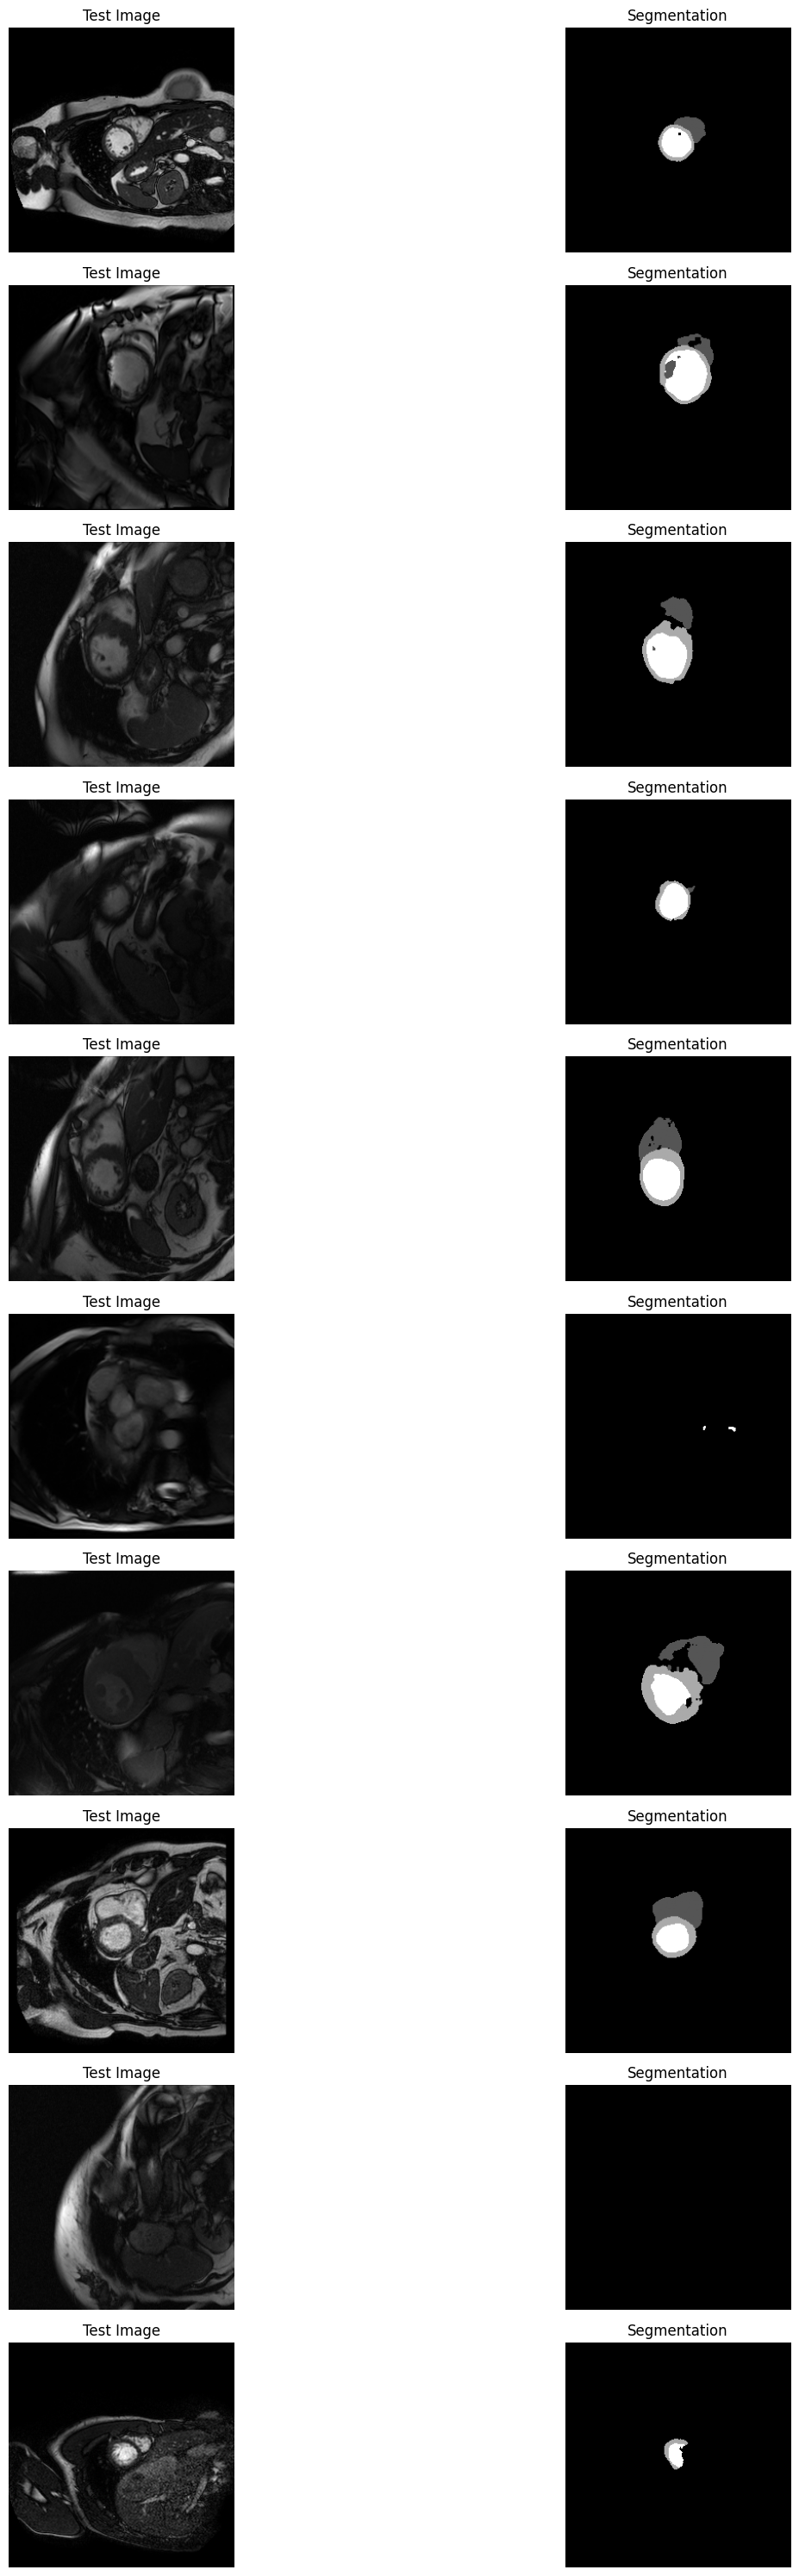

In [4]:
# Visualisation, secret test set
import os
import glob
import torch
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import monai
from monai.transforms import Compose, EnsureChannelFirstd, ScaleIntensityd, Resized
from monai.networks.nets import UNet
from monai.metrics import DiceMetric
from monai.networks.utils import one_hot
from torch.utils.data import DataLoader
import random

ensemble_model_path = "ensembleHeartUNet.pt"

#%% Load NIfTI images
def load_nii(img_path):
    nimg = nib.load(img_path)
    return nimg.get_fdata()

def build_test_dict(data_path):
    patient_dirs = [os.path.join(data_path, patient) for patient in os.listdir(data_path) 
                   if os.path.isdir(os.path.join(data_path, patient))]
    
    image_paths = []
    for patient_folder in patient_dirs:
        image_paths.extend(sorted(glob.glob(os.path.join(patient_folder, "*.nii.gz"))))
    image_paths = sorted(image_paths)

    dataset_dicts = []
    for img_path in image_paths:
        dataset_dicts.append({"img": img_path})
    return dataset_dicts

#%% Custom Transform to Load All Slices of Data
class LoadHeartData(monai.transforms.Transform):
    def __call__(self, sample):
        img_vol = load_nii(sample['img'])
        images = np.moveaxis(img_vol, -1, 0)
        slice_list = []
        for i in range(images.shape[0]):
            slice_list.append({
                'img': images[i].astype(np.float32),
                'img_meta_dict': {'affine': np.eye(2)},
            })
        return slice_list

#%% Define test transforms
test_transforms = Compose([
    LoadHeartData(),
    EnsureChannelFirstd(keys=['img'], channel_dim="no_channel"),
    ScaleIntensityd(keys=['img']),
    Resized(keys=['img'], spatial_size=(256, 256), mode=['bilinear']),
])

#%% Load and flatten the test dataset
test_dicts = build_test_dict(r'./Secret3d')
def flatten_dataset(dataset_list, transform):
    flat_list = []
    for data in dataset_list:
        flat_list.extend(transform(data))
    return flat_list

test_flat = flatten_dataset(test_dicts, test_transforms)

#%% Create test DataLoader
test_dataset = monai.data.Dataset(data=test_flat)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

#%% Define the EnsembleModel globally to avoid pickle issues
class EnsembleModel(torch.nn.Module):
    def __init__(self, models):
        super(EnsembleModel, self).__init__()
        self.models = torch.nn.ModuleList(models)

    def forward(self, x):
        # Collect and average the predictions (soft voting)
        outputs_list = [torch.softmax(model(x), dim=1) for model in self.models]
        avg_outputs = torch.mean(torch.stack(outputs_list), dim=0)
        return avg_outputs

#%% Load the saved ensemble model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ensemble_model = torch.load(ensemble_model_path, map_location=device)
ensemble_model.to(device)
ensemble_model.eval()  # Ensure the model is in evaluation mode

#%% Initialize Dice metric
dice_metric = DiceMetric(include_background=False, reduction="mean")

#%% Select 10 random test images
num_samples = 10
indices = random.sample(range(len(test_dataset)), num_samples)

#%% Visualize the results
fig, axes = plt.subplots(num_samples, 3, figsize=(10, 3 * num_samples))

# Inference and Debugging
with torch.no_grad():
    for i, idx in enumerate(indices):
        sample = test_dataset[idx]
        img = sample["img"].to(device).unsqueeze(0)  # Add batch dimension

        # Run inference with the ensemble model
        output = ensemble_model(img)
        
        # Apply softmax
        output_prob = torch.softmax(output, dim=1)

        # Apply argmax to get the predicted class
        pred = torch.argmax(output_prob, dim=1, keepdim=True)

        # Convert tensors to numpy for plotting
        img = img.squeeze().cpu().numpy()
        pred_np = pred.squeeze().cpu().numpy()


        # Plot the results
        axes[i, 0].imshow(img, cmap="gray")
        axes[i, 0].set_title("Test Image")

        axes[i, 2].imshow(pred_np, cmap="gray")
        axes[i, 2].set_title(f"Segmentation")

        for ax in axes[i]:
            ax.axis("off")

plt.tight_layout()
plt.show()

